# Analysis and model building

Showing some summary graphs and statistics for the Kumeu Weather data that will be used for weather forecasting. Historical hourly weather data is available from Jan 2016 til May 2021.

Goal to achieve:
Create a model that can predict weather varibles: temperature rainfall, humidity, windspeed.

Task list:
- ✓ Import historic data
- ✓ Plot graphs to view data
- ✓ Format and export historic data as csv
- ✓ Format and export historic data as DataFrame (in pickle format) 
- ✓ Encode and standardise data to prepare for model training
- ✓ Export standardised model data as csv and DataFrame (pickle format)
- ✓ Build model
- ✓ Train model
- ✓ Evaluate model
- ✓ Save model
- ✓ show examples of using the model
- <b> ✓ At this stage, the model is ready to be exported as an initial proof of concept for the prediction app</b>
- To do: Build, train and evaluate models with different architectures for model selection
- To do: Hyper-parameter tuning to improve the selected model
- To do: Critically analyse the strengths and weaknesses of the model and predictions
- To do: Repeat all steps for the variables: rainfall, humidity, wind-speed

## Current progress

A baseline model has been built and saved, so it can be loaded and used directly. This model takes 24 hours' of data for 5 weather variables: temperature, rainfall, wetness, humidity and windspeed. It is an array of floats, 24 x 5 in size. The model then predicts these 5 weather variables for the next 24 hours. It outputs an array of floats, 24 x 5 in size.

At present this model seems to make usable predictions for temperature, but not for other variables. Luckily for this application, temperature is one of the largest factors that determine the risk of frost. The next steps here would be to improve this model by tuning its parameters to improve its accuracy. Specifically, I would try to improve the accuracy for wind speed predictions as this is the other significant factor that impacts frost risk.

## Preliminaries: Install and import necessary libraries
If running this notebook for the first time, you will need to install all the libraries with the code below. This only needs to be done once.

In [43]:
%%capture
# Install and import libraries. %%capture is used to suppress messages for library install statuses

import sys

!{sys.executable} -m pip install -r requirements.txt

Import all the libraries required for this notebook to run.

In [2]:
import os, random, csv, re, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import plotly.express as px
import plotly.offline as pyo
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Activation, RepeatVector, TimeDistributed
from xgboost import XGBRegressor 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Suppress Tensorflow warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# displays full numbers in dataframes instead of scientific notation for clarity
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', 500)

# For model building/training
# tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(False)

## Import historic hourly Kumeu weather data and preprocessing

The hourly weather data is provided as multiple CSV files. The CSV files are imported, preprocessed and transformed into a Pandas DataFrame object.

The weather data is stored as a Pandas Data Frame. Column names, column types and null values are tidied as part of preprocessing. The dates are converted to DateTime objects (day, month, year, hour) so that they can be easily processed later. 

In [71]:
def process_metwatch_hourly_data(input_data_path_list):
    # The csv data is imported and saved as a Python list.
    input_data = []
    
    # Importing the raw data from the csv files
    for data_path in input_data_path_list:
        print("Importing data from file path: " + data_path)
        csv_list = []
        with open(data_path) as f:
            next(f)
            next(f)
            for line in f.readlines():
                if ',' in line:
                    input_data.append(line.strip().split(','))
    
    # Initial pre-processing on the raw weather data
    for i in range(len(input_data)):
        if len(input_data[i])<2:
            input_data[i] = None
            continue
        else:
            date_split = input_data[i][0].split(' ')[1:]
            date_split[0] = re.sub('[a-zA-Z]+','',date_split[0])
            date_split[-1] = date_split[-1].strip('"')
            input_data[i][0] = " ".join(date_split)
            if len(input_data[i])>1:
                input_data[i][1] = input_data[i][1].strip('"')
                input_data[i][8] = input_data[i][8].strip('"')
            for j in range(1,len(input_data[i])):
                if input_data[i][j] == '':
                    input_data[i][j] = None
                elif input_data[i][j] == '-':
                    input_data[i][j] = None
    
    # A Pandas DataFrame is created to store the weather data
    raw_df = pd.DataFrame(data=input_data, columns=['date','time_hourly','temp_C','rain_mm','wetness_percent','rel_humidity_percent',
                                     'wind_speed_kmph','wind_direction','spray_drift_risk','backup_data','missing_data'])
    
    # Defining the data types for each column in the weather data
    raw_df = raw_df.astype(dtype={'date':'object','time_hourly':'object','temp_C':'float64','rain_mm':'float64',
                                      'wetness_percent':'float64','rel_humidity_percent':'float64',
                                      'wind_speed_kmph':'float64','wind_direction':'object','spray_drift_risk':'object',
                                      'backup_data':'float64','missing_data':'object'})
    
    # Creating date time objects to represent time in weather data
    raw_df['max_hour_str'] = raw_df['time_hourly'].str.split('-').str[-1].str.strip() 
    raw_df['datetime_mid']= pd.to_datetime(raw_df['date'] + raw_df['max_hour_str'], format='%d %b %Y%I%p') - pd.Timedelta(minutes=30)
    raw_df['end_hour'] = pd.to_datetime(raw_df['max_hour_str'], format='%I%p').dt.hour
    raw_df['start_hour'] = raw_df['end_hour'] - 1
    raw_df.loc[raw_df['start_hour']==-1, 'start_hour'] = 23
    raw_df['day'] = raw_df['datetime_mid'].dt.day
    raw_df['month'] = raw_df['datetime_mid'].dt.month
    raw_df['year'] = raw_df['datetime_mid'].dt.year

    train_df = raw_df[['datetime_mid','temp_C','rain_mm','wetness_percent','rel_humidity_percent','wind_speed_kmph','wind_direction','spray_drift_risk','backup_data','missing_data','year','month','day','start_hour','end_hour']]
    train_df = train_df.set_index('datetime_mid')
    
    # Print a sample of the pre-processed data.
    return train_df

In [61]:
data_dir = "../data/Weather Station Hourly/"

input_data_paths = [data_dir+"MetWatch Export (20{}).csv".format(i) for i in range(16,22)]
input_data_paths

['../data/Weather Station Hourly/MetWatch Export (2016).csv',
 '../data/Weather Station Hourly/MetWatch Export (2017).csv',
 '../data/Weather Station Hourly/MetWatch Export (2018).csv',
 '../data/Weather Station Hourly/MetWatch Export (2019).csv',
 '../data/Weather Station Hourly/MetWatch Export (2020).csv',
 '../data/Weather Station Hourly/MetWatch Export (2021).csv']

In [ ]:
process_metwatch_hourly_data(input_data_path_list)

A sample of this pre-processed data is printed below.

In [48]:
train_df.sample(2)

,temp_C,rain_mm,wetness_percent,rel_humidity_percent,wind_speed_kmph,wind_direction,spray_drift_risk,backup_data,missing_data,year,month,day,start_hour,end_hour
datetime_mid,,,,,,,,,,,,,,
2017-06-12 04:30:00,6.800000,0.000000,98.500000,100.000000,0.200000,S,Not Recommended,NaN,None,2017,6,12,4,5
2016-03-07 03:30:00,NaN,NaN,NaN,NaN,NaN,None,None,NaN,All,2016,3,7,3,4


## Handling missing values
There are around 8% missing values in the dataset (approx. 3,500 out of the 46,825 hourly records). Most of the missing data is found in Jan - May 2016. The missing data values are filled in two ways:
1. If there is 1 missing value, neighboured by two filled values in the previous and next record (hour), then the record is filled by copying the previous hour's value.
2. If there is more than 1 missing value in a row (more than 1 consecutive hour of data missing), then these values are filled using an average value. These values are calculated as the average value for that hour, day and month across the entire dataset (2016-2021).

In [49]:
# If there is a gap of just 1 record, then fill it with the previously observed value
train_df.fillna(method='ffill', inplace=True, limit=1)

In [50]:
# Calculating the average weather measurements for each month, day and hour across the entire dataset (2016-2021)
month_day_hour_avg = train_df.groupby(["month","day","start_hour","end_hour"]).aggregate(np.mean)
month_day_hour_avg

temp_C  rain_mm  wetness_percent  \
month day start_hour end_hour                                       
1     1   0          1        15.060000 0.000000        81.040000   
          1          2        14.320000 0.000000        87.240000   
          2          3        13.900000 0.000000        82.180000   
          3          4        13.540000 0.000000        79.680000   
          4          5        13.020000 0.000000        74.980000   
...                                 ...      ...              ...   
12    30  20         21       17.520000 0.000000        13.580000   
          21         22       15.960000 0.000000        31.900000   
          22         23       14.640000 0.000000        76.940000   
      31  0          1        13.580000 0.000000        76.860000   
          23         0        16.940000 0.000000        75.820000   

                               rel_humidity_percent  wind_speed_kmph  \
month day start_hour end_hour                                          
1     1   0          1                    94.180000         0.920000   
          1          2                    95.260000         0.300000   
          2          3                    96.140000         0.540000   
          3          4                    96.600000         0.480000   
          4          5                    96.740000         0.700000   
...                                             ...              ...   
12    30  20         21                   77.780000         7.200000   
          21         22                   84.920000         3.320000   
          22         23                   89.760000         2.060000   
      31  0          1                    93.480000         1.980000   
          23         0                    92.200000         1.300000   

                               backup_data        year  
month day start_hour end_hour                           
1     1   0          1                 NaN 2018.500000  
          1          2                 NaN 2018.500000  
          2          3                 NaN 2018.500000  
          3          4                 NaN 2018.500000  
          4          5                 NaN 2018.500000  
...                                    ...         ...  
12    30  20         21                NaN 2018.000000  
          21         22                NaN 2018.000000  
          22         23                NaN 2018.000000  
      31  0          1                 NaN 2018.000000  
          23         0                 NaN 2017.500000  

[8761 rows x 7 columns]

In [51]:
# Fill all other missing values with the average values across entire dataset

columns = ['temp_C','rain_mm','wetness_percent','rel_humidity_percent','wind_speed_kmph']
for index, row in train_df.iterrows():
    if row.isna().sum()== 0:
        continue
    for column in columns:
        if np.isnan(row[column]):
            month, day, start_hour, end_hour = row['month'], row['day'], row['start_hour'], row['end_hour']
            train_df.loc[index, column] = month_day_hour_avg.loc[month, day, start_hour, end_hour][column]

Now that the null values have been processed, the table below shows the resulting number of null values in the datset. The weather attributes that have 0 null values have been fully filled in: temperature, rainfall, wetness, relative humidity and windspeed.

In [52]:
train_df.isnull().sum()

temp_C                      0
rain_mm                     0
wetness_percent             0
rel_humidity_percent        0
wind_speed_kmph             0
wind_direction           3452
spray_drift_risk         3882
backup_data             46825
missing_data            42898
year                        0
month                       0
day                         0
start_hour                  0
end_hour                    0
dtype: int64

## Graphs
Visual graph of temperature data. Data appears seasonal a high level (year and month level). Seasonality patterns are not as strong, and there are some irregularities when looking at temperature on the granular hourly level.

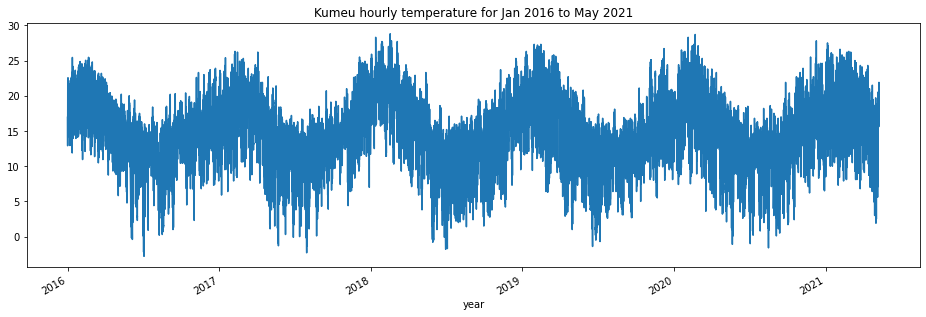

In [55]:
total_temp_plot = train_df['temp_C'].plot(figsize=(16,5),title='Kumeu hourly temperature for Jan 2016 to May 2021',xlabel='year')

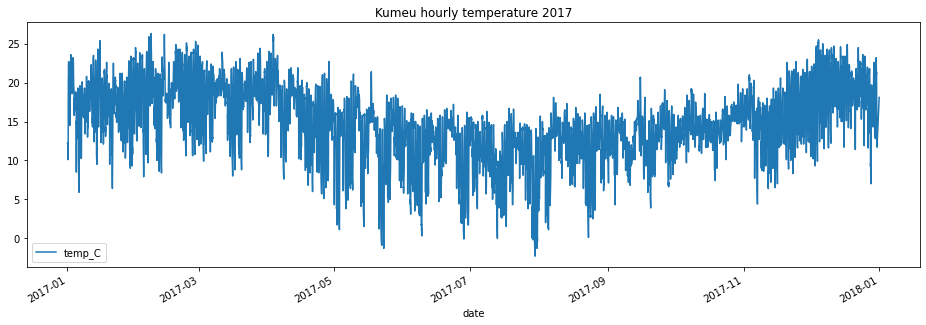

In [56]:
temp_2017 = train_df[['temp_C']].loc[train_df.index.year==2017].plot(figsize=(16,5),title='Kumeu hourly temperature 2017',xlabel='date')

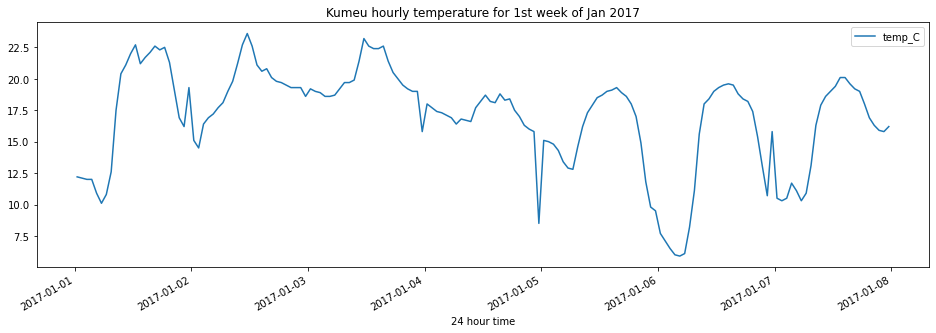

In [57]:
temp_1week = train_df[['temp_C']].loc[(train_df.index.year==2017) & (train_df.index.month==1) & (train_df.index.day<8)].plot(figsize=(16,5),title='Kumeu hourly temperature for 1st week of Jan 2017',xlabel='24 hour time')

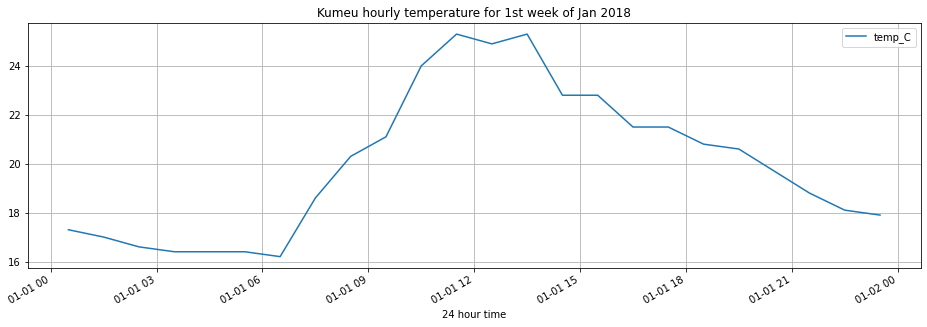

In [58]:
temp_1week = train_df[['temp_C']].loc[(train_df.index.year==2018) & (train_df.index.month==1) & (train_df.index.day==1)].plot(figsize=(16,5),title='Kumeu hourly temperature for 1st week of Jan 2018',xlabel='24 hour time', grid=True)

## Checkpoint: save data (optional)
The input weather data is now formatted. Output as csv and pickle file.
The pickle file (.pkl) is a copy of the pre-processed DataFrame so you don't need to repeat the steps above.

In [53]:
train_df.to_csv('../data/hourly_2016_2021.csv')
train_df.to_pickle('../data/hourly_2016_2021.pkl')

## Checkpoint: load raw train dataset (optional)
You can run the code below to start the notebook from this point. This saves time as you won't need to run any of the processing steps above.

In [2]:
train_df = pd.read_pickle('../data/hourly_2016_2021.pkl')

In [4]:
train_df.head()

,temp_C,rain_mm,wetness_percent,rel_humidity_percent,wind_speed_kmph,wind_direction,spray_drift_risk,backup_data,missing_data,year,month,day,start_hour,end_hour
datetime_mid,,,,,,,,,,,,,,
2016-01-01 00:30:00,15.060000,0.000000,81.040000,94.180000,0.920000,None,None,NaN,All,2016,1,1,0,1
2016-01-01 01:30:00,14.320000,0.000000,87.240000,95.260000,0.300000,None,None,NaN,All,2016,1,1,1,2
2016-01-01 02:30:00,13.900000,0.000000,82.180000,96.140000,0.540000,None,None,NaN,All,2016,1,1,2,3
2016-01-01 03:30:00,13.540000,0.000000,79.680000,96.600000,0.480000,None,None,NaN,All,2016,1,1,3,4
2016-01-01 04:30:00,13.020000,0.000000,74.980000,96.740000,0.700000,None,None,NaN,All,2016,1,1,4,5


## Preparing data for model training

The data needs to be transformed before it can be input into a neural network model. The following steps are taken in this section:

- One Hot Encoding
- Normalisation

### Option 1: including wind direction data
Perform one hot encoding for all wind direction categories. The sample below shows the result. This affects Wind Direction only as it is the only categorical column only. For each row, all wind direction columns are 0 except for 1, which represents the correct wind direction category for that row.

<b>Note: One Hot Encoding is not used in the Zaytar and Amrani model (2016) model</b>

In [11]:
# train_df.drop(labels=['year','month','day','start_hour','end_hour','backup_data','spray_drift_risk','missing_data'], 
#               axis=1, inplace=True)

# train_df_encoded = pd.get_dummies(train_df, drop_first=True)

# #put temperature at the end of the dataframe because that will be the label - the value we are trying to predict
# train_df_encoded = train_df_encoded[['rain_mm','wetness_percent','rel_humidity_percent','wind_speed_kmph',
#                                     'wind_direction_N','wind_direction_NE','wind_direction_NW','wind_direction_S',
#                                     'wind_direction_SE','wind_direction_SW','wind_direction_W','temp_C']]

# train_df_encoded.sample(5)

### Option 2: excluding wind direction data
The cell below only retains rainfall, wetness, humidity and temperature and wind speed (same variables that were used in Zaytar 2016). 

In [6]:
# Drop wind data
def drop_wind_direction(df):
    df.drop(labels=['year','month','day','start_hour','end_hour','backup_data','spray_drift_risk','missing_data', 'wind_direction'], 
              axis=1, errors='ignore', inplace=True)
    return df

train_df = drop_wind_direction(train_df)
train_df.head()

,temp_C,rain_mm,wetness_percent,rel_humidity_percent,wind_speed_kmph
datetime_mid,,,,,
2016-01-01 00:30:00,15.060000,0.000000,81.040000,94.180000,0.920000
2016-01-01 01:30:00,14.320000,0.000000,87.240000,95.260000,0.300000
2016-01-01 02:30:00,13.900000,0.000000,82.180000,96.140000,0.540000
2016-01-01 03:30:00,13.540000,0.000000,79.680000,96.600000,0.480000
2016-01-01 04:30:00,13.020000,0.000000,74.980000,96.740000,0.700000


Here is what the data looks like after performing Min-Max scaling normalisation. The data ranges for all columns is -1 to 1. The data column names have also disappeared and are just numbers as this is required for model input.

In [7]:
def scale_data(full_data_df, data_to_scale_df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(full_data_df)
    data_df_scaled = pd.DataFrame(scaler.transform(data_to_scale_df))
    return data_df_scaled, scaler

train_df_scaled, scaler = scale_data(train_df, train_df)

train_df_scaled.sample(5)

,0,1,2,3,4
23988,0.113924,-1.000000,-0.996000,-0.130307,-0.127479
34194,0.405063,-1.000000,-0.994000,0.136164,-0.830028
7841,0.329114,-1.000000,-0.996000,0.144949,-0.314448
17873,0.550633,-1.000000,-0.996000,0.428990,0.087819
32932,0.006329,-1.000000,-0.816000,0.821376,-0.450425


## Checkpoint: save data (optional)

The input data is now formatted for neural network implementation. The data is saved as a csv file and also a pickle file. The pickle file can be loaded directly into a Python script so that you can skip all the above steps and start working directly with the data formatted for model implementation.

In [8]:
train_df_scaled.to_csv('../data/hourly_2016_2021_scaled.csv')
train_df_scaled.to_pickle('../data/hourly_2016_2021_scaled.pkl')

## Checkpoint: load data (optional)

You can run the code below to start the notebook from this point. This saves time as you won't need to run any of the processing steps above.

In [5]:
train_df_scaled = pd.read_pickle('../data/hourly_2016_2021_scaled.pkl')

## Data conversion

Now the data will be converted from DataFrame object to Numpy array because this format is required for model input.

In [6]:
train_df_scaled = train_df_scaled.to_numpy()
train_df_scaled.shape

(46825, 5)

## Zaytar and Amrani model (2016)

There was a paper written in 2016 by Zaytar and Amrani where a neural network was built to create hourly weather forecasts for the variables: rainfall, temperature and humidity. I have decided to recreate this model's architecture to see if it is suitable for forecasts for our dataset. Below is a diagram of this model's architecture:

<img src="../images/Zaytar_Amrani_2016_LSTM architecture.png" />

Source: Zaytar, M. A., & El Amrani, C. (2016). Sequence to sequence weather forecasting with long short-term memory recurrent neural networks. International Journal of Computer Applications, 143(11), 7-11.

## Train/test data split

The data is now sliced into the appropriate dimensions for the Zaytar & Amrani (2016) model. The model will use hourly data from the past 5 days (168 hours) to predict the next 24 hours of data. There are 46,634 records in the dataset in total.

trainX = the past 5 days of hourly data
trainY = the 6th day of data to predict

In [13]:
# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
trainX = []
trainY = []

n_future = 24  # Number of days we want to predict into the future
n_past = 24  # Number of past days we want to use to predict the future

for i in range(n_past, len(train_df_scaled) - n_future +1):
    trainX.append(train_df_scaled[i - n_past:i, 0:train_df_scaled.shape[1]])
    trainY.append(train_df_scaled[i:i + n_future, 0:train_df_scaled.shape[1]])
    #trainY.append(train_df_encoded_scaled[i + n_future - 1:i + n_future, -1])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape: {}.'.format(trainX.shape))
print('trainY shape: {}.'.format(trainY.shape))

trainX shape: (46778, 24, 5).
trainY shape: (46778, 24, 5).


## Build model
Building and compiling the model from Zaytar and Amrani (2016). The RMSprop formula is used as the optimisation function and mean square error (mse) is used as the loss function - this is consistent with the authors' implementation.

In [14]:
# LSTM architecture from Zaytar and Amrani (2016), modified to fit our dataset
model = Sequential(name='zaytar_amrani_2016')

model.add(LSTM(trainX.shape[2], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True, name = 'lstm1'))
model.add(LSTM(100, activation='relu', return_sequences=False, name='lstm2'))
model.add(Dense(100, name='dense'))
model.add(Activation(activation='relu', name='activation'))
model.add(RepeatVector(n=24, name = 'repeat'))
model.add(LSTM(100, activation='relu', return_sequences=True, name='lstm3'))
model.add(LSTM(100, activation='relu', return_sequences=True, name='lstm4'))
model.add(TimeDistributed(Dense(trainX.shape[2]), name='timedistributed'))
#model.add(Dense(trainY.shape[1], name = "dense2"))

#model.compile(optimizer='adam', loss='mse')


opt = RMSprop(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt)

model.summary()

Model: "zaytar_amrani_2016"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 24, 5)             220       
_________________________________________________________________
lstm2 (LSTM)                 (None, 100)               42400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
repeat (RepeatVector)        (None, 24, 100)           0         
_________________________________________________________________
lstm3 (LSTM)                 (None, 24, 100)           80400     
_________________________________________________________________
lstm4 (LSTM)                 (None, 24, 100)    

In [ ]:
# Train the model
# Save the model at each epoch as checkpoints and also implement early stopping to prevent the model from overfitting
my_callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='../models/checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    TensorBoard(log_dir='../models/logs'),
]

history = model.fit(trainX, trainY, 
                    epochs=100, batch_size=32, 
                    validation_split=0.1,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/100
1316/1316 [==============================] - 95s 72ms/step - loss: 0.1625 - val_loss: 0.1567
Epoch 2/100
1316/1316 [==============================] - 100s 76ms/step - loss: 0.1378 - val_loss: 0.1393
Epoch 3/100
1316/1316 [==============================] - 98s 74ms/step - loss: 0.1280 - val_loss: 0.1329
Epoch 4/100
1316/1316 [==============================] - 88s 67ms/step - loss: 0.1230 - val_loss: 0.1246
Epoch 5/100
1316/1316 [==============================] - 91s 69ms/step - loss: 0.1195 - val_loss: 0.1214
Epoch 6/100
1316/1316 [==============================] - 98s 75ms/step - loss: 0.1169 - val_loss: 0.1149
Epoch 7/100
1316/1316 [==============================] - ETA: 0s - loss: 0.1150

## Checkpoint: save model (optional)
Saving model to local file so that it can be loaded without needing to rebuilt/retrained.

In [10]:
model.save('../models/zaytar_amrani_2016_1')

INFO:tensorflow:Assets written to: ../models/zaytar_amrani_2016_1\assets


## Checkpoint: load model (optional)
Load the trained model so that it can used for weather predictions.

In [50]:
model = tf.keras.models.load_model('../models/zaytar_amrani_2016')

## Model evaluation

Here is a plot of the loss values during model training. The train and test loss values decrease over time and are very similar. This means that the model are successfully learning and are not overfitting nor underfitting. It appears the losses have not streamlined, so the model could be further improved with more epochs in training.

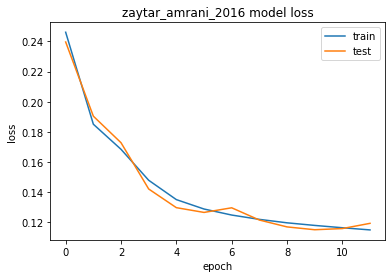

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('zaytar_amrani_2016 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

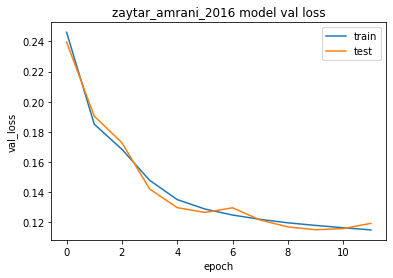

In [12]:
# summarize history for val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('zaytar_amrani_2016 model val loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Using the model to make weather predictions

Here I will show how to use the model and show some examples of its weather predictions vs. reality.
The training data used spanned 2016 til May 2021. 

I've selected 6 days at random from the new set of unseen data and have used the model to predict temperature. Then I have drawn graphs to compare the predicted temperatures vs. the actual temperatures.

The steps are as follows:

1. Import the model from a saved file. It will be a path to a folder named 'zaytar_amrani_2016'
2. Prepare the input data. The input data must be 24 hours of data from 0:00 - 23:00 and contain the 5 variables in this order order:
- Temperature
- rain
- wetness
- humidity
- windspeed
3. All variables must be standardised using the Min Max scaler, defined by the min/max values in the full train dataset (2016-2021).
4. Call the function model.predict(x) to retrieve the prediction values. x is an array of numbers, consisting 24 rows, with 5 columns each, representing the 24 hours of data.
5. Use the Min Max scaler object to perform an inverse transform to turn these scaled values back to their original units.
6. Now you have an array of 24 values, which represent the hourly predictions for the next day, for each of the 5 variables.

## Preliminary processing

Importing and processing the test data that will be used to demonstrate these predictions. These pre-processing steps are identical to the ones used for preparing the training data, so I won't repeat this information here.

I've picked 6 random days and have prepared 3D arrays for each of the 5 variables for each hour, for each day. Then I put all of the 6 random days of data into the model to make the predictions. I then extracted the actual temperature data from the dataset as the ground truth. 

In [325]:
input_data_path_list = [data_dir+"MetWatch Export (from May 2021).csv"]
# Preprocessing data
latest_data_df = process_metwatch_hourly_data(input_data_path_list)
# Fill missing data
latest_data_df.fillna(method='ffill', inplace=True, limit=1)
# Drop wind direction data
latest_data_df = drop_wind_direction(latest_data_df)

# Pick some random days to do predictions
truth_0510 = latest_data_df.loc[(latest_data_df.index.month==5) & (latest_data_df.index.day == 10)]
truth_0717 = latest_data_df.loc[(latest_data_df.index.month==7) & (latest_data_df.index.day == 17)]
truth_0515 = latest_data_df.loc[(latest_data_df.index.month==5) & (latest_data_df.index.day == 15)]
truth_0728 = latest_data_df.loc[(latest_data_df.index.month==7) & (latest_data_df.index.day == 28)]
truth_0605 = latest_data_df.loc[(latest_data_df.index.month==6) & (latest_data_df.index.day == 5)]
truth_0620 = latest_data_df.loc[(latest_data_df.index.month==6) & (latest_data_df.index.day == 20)]

test_x = truth_0510.append(truth_0717).append(truth_0515).append(truth_0728).append(truth_0605).append(truth_0620)
# Enter the full training data to build the scaler using the min/max values from the full dataset
test_x_scaled, scaler = scale_data(train_df, test_x)

# Creating a new array for the hourly data for the 6 ranomly sampled days
test_x_array = []
test_x_scaled_np = test_x_scaled.to_numpy()
for i in range(0, test_truth_scaled.shape[0], 24):
    test_x_array.append(test_x_scaled_np[i:i+24, 0:test_x_scaled.shape[1]])
test_X = np.array(test_x_array)
prediction_sample = model.predict(test_X)
# Transform values from scaled -1 to 1 range back to its original units
prediction_values = []
for i in range(6):
    prediction_values.append(scaler.inverse_transform(prediction_sample[i]))

def get_truth_values(df, month, day, column_name):
    truth_values = list(df.loc[(df.index.month==month) & (df.index.day == day)][column_name])
    return truth_values

# Label 0 to 23 hours on the x axis for graphs to represent 24 hour time
x_axis = [i for i in range(24)]

Importing data from file path: ../data/Weather Station Hourly/MetWatch Export (from May 2021).csv


## Plotting predictions vs. ground truth

I plotted the actual measured data against the predictions made by the model. It looks like the accuracy varies quite a lot between different days for different attributes. The results seem to predict temperature adequately enough to be useable as a baseline. Wind speed does not seem to predict well enough to be useable for a baseline. Discrepencies could also be due to random error from the sensor (thermometer), creating errors which cannot be predicted by the model. For example, the trend pattern for temperature on June 6 doesn't seem to match a typical day of temperature, which could be attributed to errors in the source data.

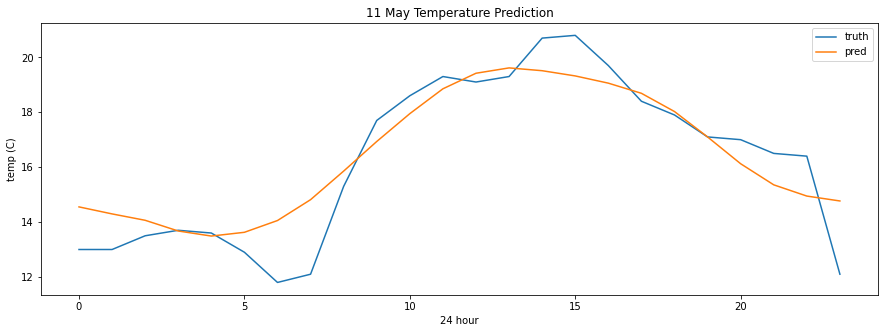

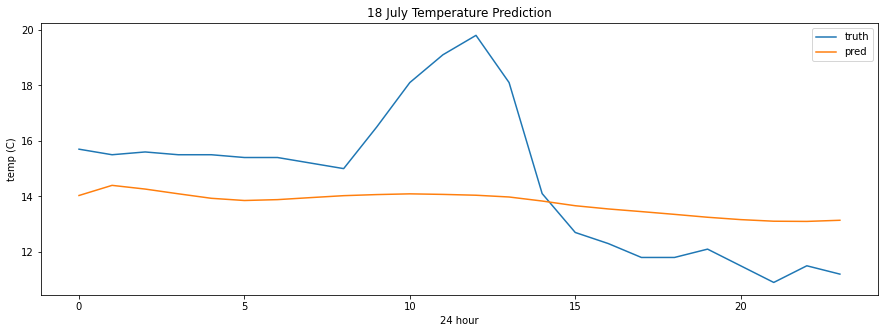

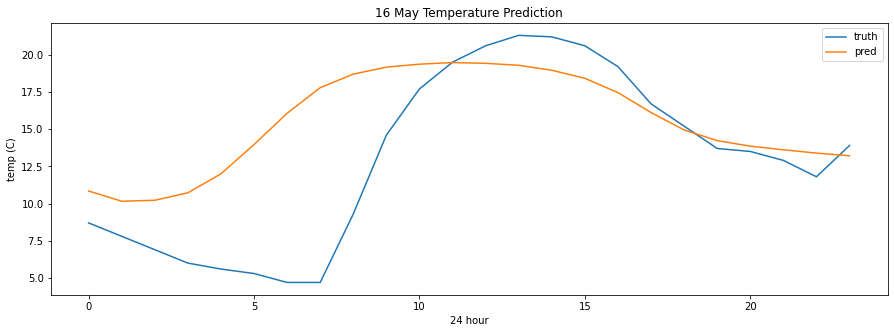

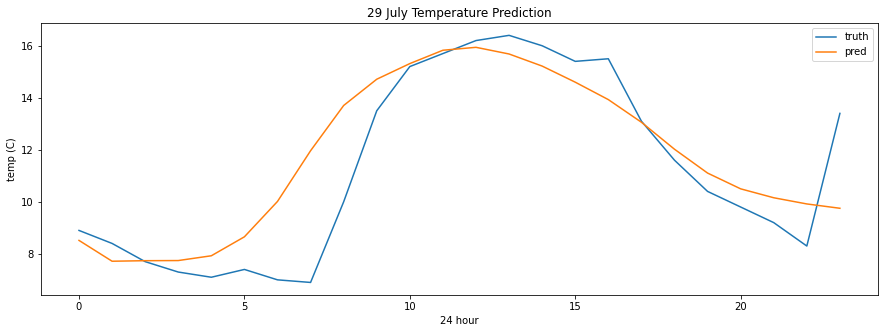

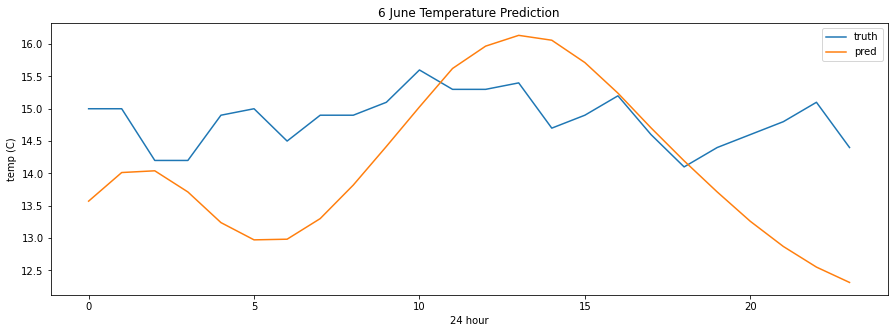

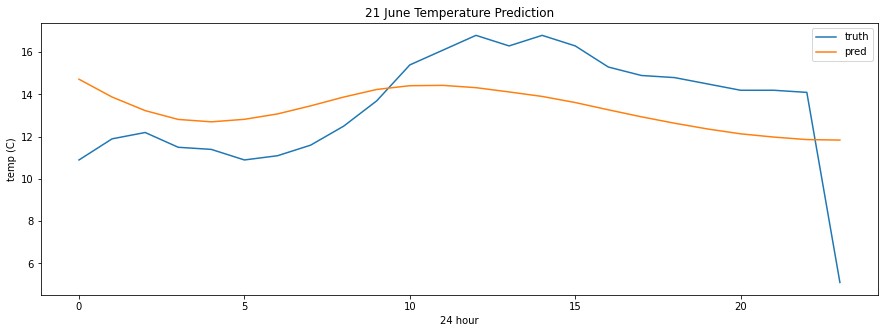

In [322]:
# Extract predicted temperature values for the sampled test days
temp_pred_0511 = prediction_values[0][:,0]
temp_pred_0718 = prediction_values[1][:,0]
temp_pred_0516 = prediction_values[2][:,0]
temp_pred_0729 = prediction_values[3][:,0]
temp_pred_0606 = prediction_values[4][:,0]
temp_pred_0621 = prediction_values[5][:,0]

plt.figure(figsize=(15,5))
plt.title('11 May Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 11, 'temp_C'))
plt.plot(x_axis, temp_pred_0511)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('18 July Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 7, 18, 'temp_C'))
plt.plot(x_axis, temp_pred_0718)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('16 May Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 16, 'temp_C'))
plt.plot(x_axis, temp_pred_0516)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('29 July Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 7, 29, 'temp_C'))
plt.plot(x_axis, temp_pred_0729)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('6 June Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 6, 'temp_C'))
plt.plot(x_axis, temp_pred_0606)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('21 June Temperature Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 21, 'temp_C'))
plt.plot(x_axis, temp_pred_0621)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('temp (C)')
plt.show()

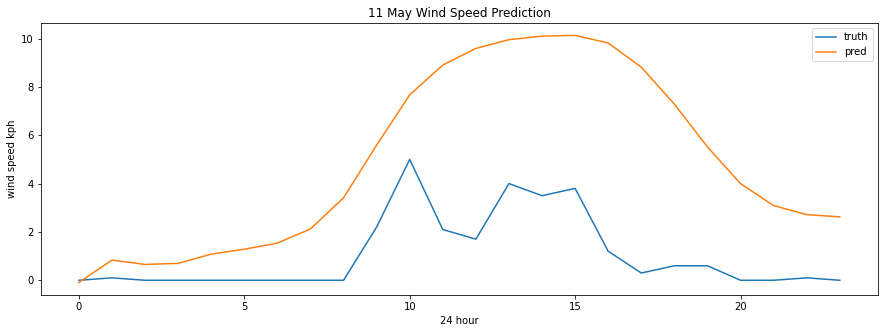

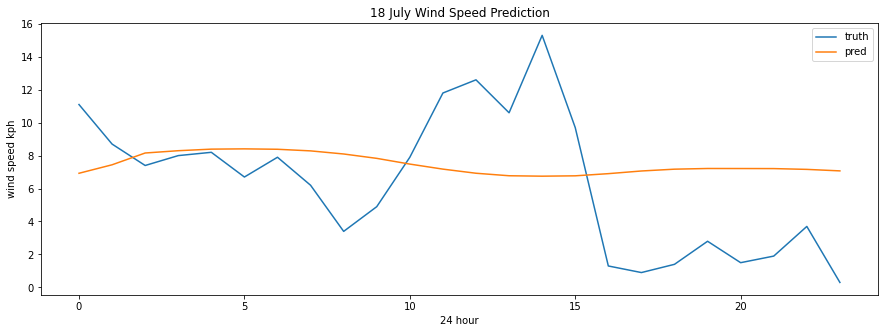

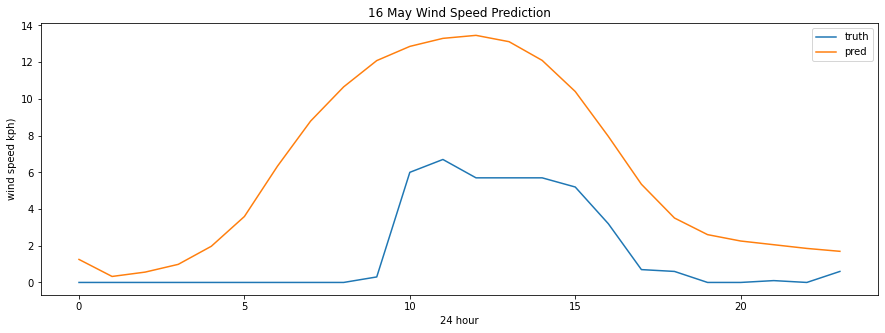

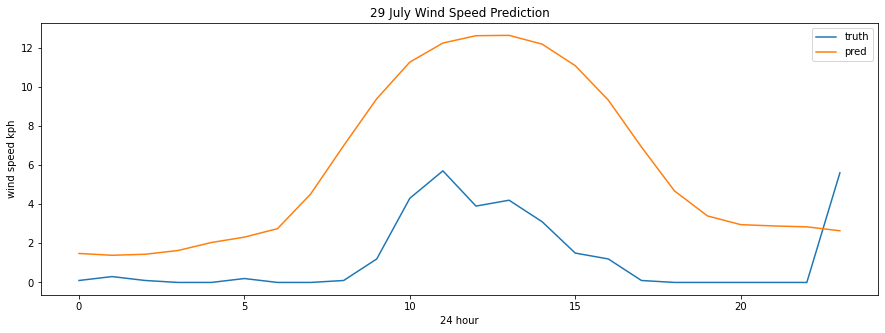

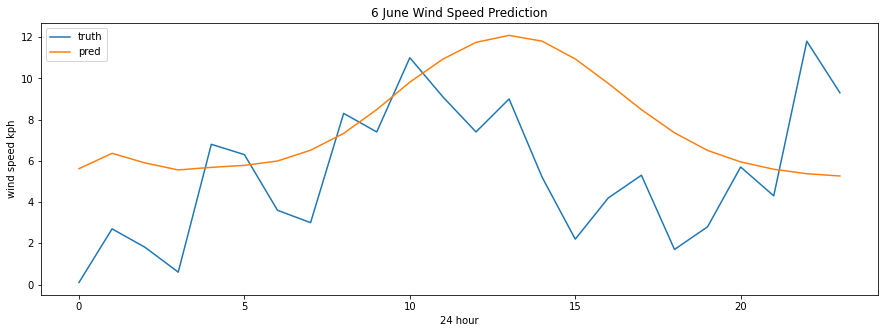

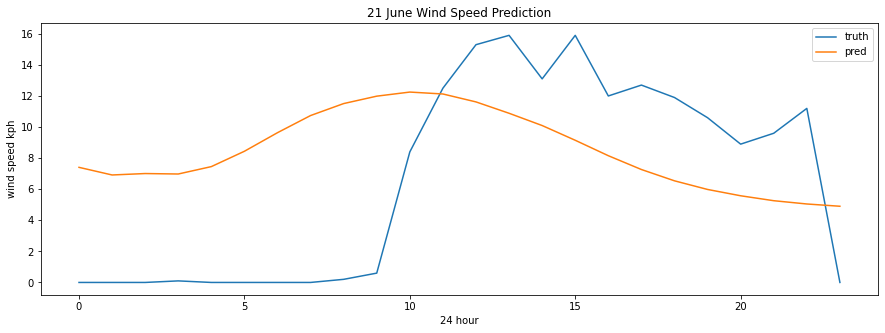

In [327]:
# Extract predicted wind speed values for the sampled test days
wind_pred_0511 = prediction_values[0][:,4]
wind_pred_0718 = prediction_values[1][:,4]
wind_pred_0516 = prediction_values[2][:,4]
wind_pred_0729 = prediction_values[3][:,4]
wind_pred_0606 = prediction_values[4][:,4]
wind_pred_0621 = prediction_values[5][:,4]

plt.figure(figsize=(15,5))
plt.title('11 May Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 11, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0511)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph')
plt.show()

plt.figure(figsize=(15,5))
plt.title('18 July Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 7, 18, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0718)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph')
plt.show()

plt.figure(figsize=(15,5))
plt.title('16 May Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 16, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0516)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('29 July Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 7, 29, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0729)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph')
plt.show()

plt.figure(figsize=(15,5))
plt.title('6 June Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 6, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0606)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph')
plt.show()

plt.figure(figsize=(15,5))
plt.title('21 June Wind Speed Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 21, 'wind_speed_kmph'))
plt.plot(x_axis, wind_pred_0621)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('wind speed kph')
plt.show()

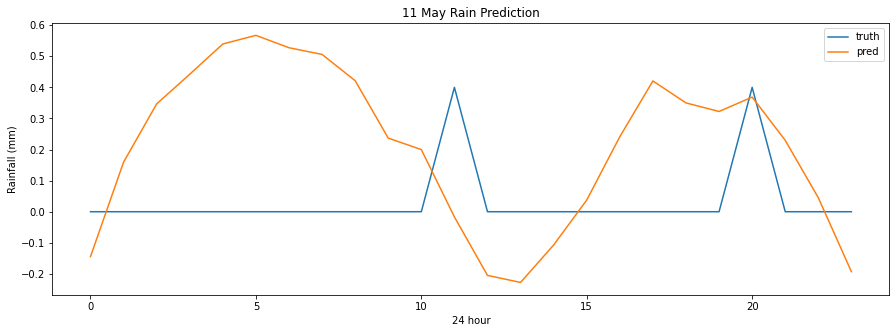

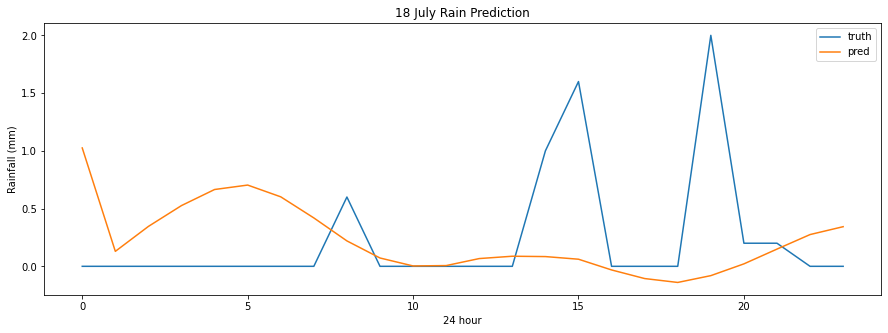

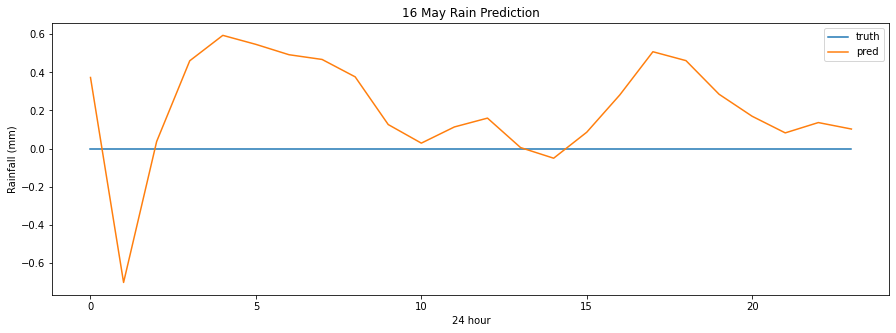

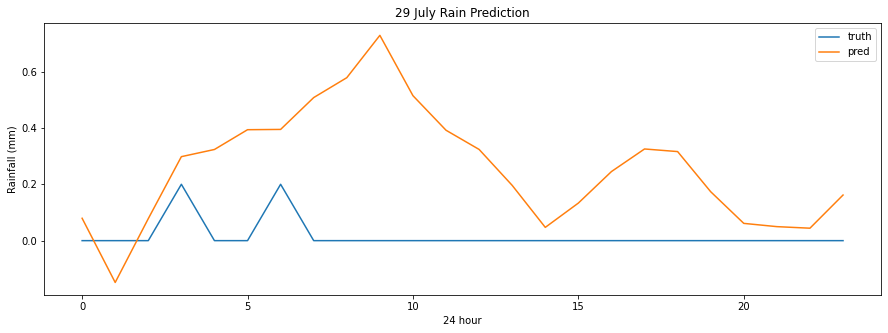

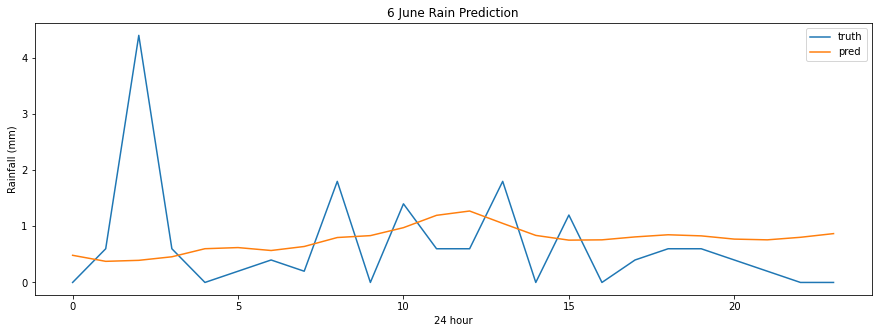

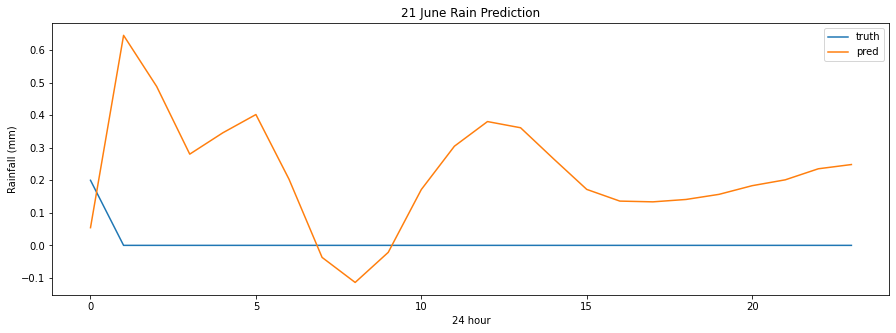

In [328]:
# Extract predicted rainfall values for the sampled test days
rain_pred_0511 = prediction_values[0][:,1]
rain_pred_0718 = prediction_values[1][:,1]
rain_pred_0516 = prediction_values[2][:,1]
rain_pred_0729 = prediction_values[3][:,1]
rain_pred_0606 = prediction_values[4][:,1]
rain_pred_0621 = prediction_values[5][:,1]

plt.figure(figsize=(15,5))
plt.title('11 May Rain Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 11, 'rain_mm'))
plt.plot(x_axis, rain_pred_0511)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('18 July Rain Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 7, 18, 'rain_mm'))
plt.plot(x_axis, rain_pred_0718)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('16 May Rain Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 5, 16, 'rain_mm'))
plt.plot(x_axis, rain_pred_0516)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('29 July Rain Prediction')
, plt.plot(x_axis, get_truth_values(latest_data_df, 7, 29, 'rain_mm'))
plt.plot(x_axis, rain_pred_0729)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('6 June Rain Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 6, 'rain_mm'))
plt.plot(x_axis, rain_pred_0606)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()

plt.figure(figsize=(15,5))
plt.title('21 June Rain Prediction')
plt.plot(x_axis, get_truth_values(latest_data_df, 6, 21, 'rain_mm'))
plt.plot(x_axis, rain_pred_0621)
plt.legend(['truth','pred'])
plt.xlabel('24 hour')
plt.ylabel('Rainfall (mm)')
plt.show()